In [1]:
import ee
import datetime
import os
import itertools
import sys
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [2]:
ee.Initialize()

In [3]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('..')

In [4]:
from BackGround_modules.Class_2_Classify_Fourier_Img   import Classification
from BackGround_modules.Class_3_Calculate_the_accuracy import Accuracy_assesment

##### Define basic data

In [5]:
# define the years to be classified
year_name  = list([f'{span[0]}_{span[1]}' for span in zip(range(1990,2020,3),range(1992,2020,3)) ])

# import north_china_plain boundary
North_China_Plain = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

In [6]:
# Fetch the control samples
Control_sample = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Control_points")

#### Calculate the accuracy of GAIA datasets

In [7]:
GAIA = ee.Image("users/wangjinzhulala/Gloable_Imprevious_area").clip(North_China_Plain)

In [8]:
# link the year with its pixel value
GAIA_year = range(1985,2019)
GAIA_value   = range(34,0,-1)
GAIA_year_value = {i[0]:i[1] for i in zip(GAIA_year,GAIA_value)}

# difine the end years for this research
Fourier_end_years = list(range(1992,2018,3)) + [2018]

In [9]:
GAIA_acc = {}

for i,end_year in enumerate(Fourier_end_years):
    
    
    # get the pixel value of coresponded end_year
    # rename the GAIA to 'classificaiton' so that the name
    # is consistent with the Accuracy_assessment module
    GAIA_pixel_value = GAIA_year_value[end_year]
    
    # conver pixel value greater than GAIA_pixel_value to 0,other pixel to 1
    # so we get all target-year pixel with value 1
    GAIA_within_year = GAIA.gt(GAIA_pixel_value).rename('classification')
    
    # extract reclassified GAIA pixel value to test_sample
    test_with_GAIA = GAIA_within_year.sampleRegions(collection = Control_sample, 
                                                    properties = ['Built'], 
                                                    scale      = 30)
    # compute the accuracy 
    GAIA_acc[end_year] = Accuracy_assesment(test_with_GAIA).Stp_1_Calculate_Accuracy()
    
    # print out the process
    print(f'Accuracy computation of {end_year} complete!')
    

Accuracy computation of 1992 complete!
Accuracy computation of 1995 complete!
Accuracy computation of 1998 complete!
Accuracy computation of 2001 complete!
Accuracy computation of 2004 complete!
Accuracy computation of 2007 complete!
Accuracy computation of 2010 complete!
Accuracy computation of 2013 complete!
Accuracy computation of 2016 complete!
Accuracy computation of 2018 complete!


In [10]:
# Formatting the GAIA_accuracy dataframe
GAIA_acc_df = pd.DataFrame(GAIA_acc).T
GAIA_acc_df.index.name = 'End_year'

##### Save the acc_df to local disk

In [11]:
# # reset index so can drwo them togeter
# GAIA_acc_df.reset_index(inplace=True)

# # save the GAIA_acc to disk
# GAIA_acc_df.to_csv('ACC_Result/GAIA_accuracy.csv',index=False)

# read acc_df
GAIA_acc_df = pd.read_csv('ACC_Result/GAIA_accuracy.csv',index_col=0)
GAIA_acc_df.reset_index(inplace=True)

My_acc_df = pd.read_csv('../Sub_Process_7_Classification_on_img/Result/Classification_Accuracy.csv')
My_acc_df.index = [np.repeat(Fourier_end_years,len(year_name))]
My_acc_df.reset_index(inplace=True)

# get the classification accuracy of this research
GAIA_acc_df['explode'] = [[0] * 10] * 10
GAIA_acc_df = GAIA_acc_df.explode('explode')
GAIA_acc_df.reset_index(inplace=True,drop=True)

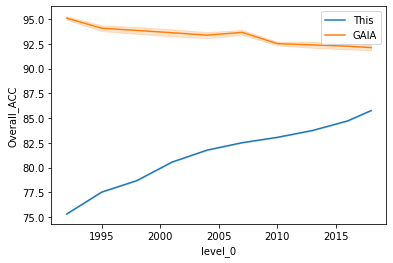

In [12]:
sns.lineplot(data=GAIA_acc_df,x ='End_year', y ='Overall_ACC',label='This')
sns.lineplot(data=My_acc_df  ,x ='level_0',  y ='Overall_ACC',label='GAIA')